In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from imutils import paths
from tqdm import tqdm
from keras.models import load_model
import keras.backend as K
import keras
from scipy.stats import norm
import tensorflow as tf
import matplotlib.animation as animation
from sklearn import metrics 
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import PCA
from numpy.linalg import svd

import pandas as pd
import random
from sklearn.manifold import TSNE
import seaborn as sns
import glob
from scipy import misc
import sklearn
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import filters
from keras.models import Sequential, Model
from keras.applications.vgg19 import VGG19
import tensorflow_probability as tfp
from functools import partial
from tensorflow_addons.layers import SpectralNormalization
from scipy.linalg import sqrtm
from functools import partial
from random import shuffle
from keras.layers.convolutional import Conv2D, InputSpec
from keras import initializers
from keras.layers import Input, Dense
from matplotlib.patches import Rectangle
import tensorflow_addons as tfa
import scipy.stats as st
from scipy.stats import wasserstein_distance

In [2]:
from platform import python_version
print(python_version())
print(tf.__version__)
print(keras.__version__)
tf.config.list_physical_devices('GPU')

3.9.10
2.6.2
2.6.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import GPUtil
from tabulate import tabulate
gpu = GPUtil.getGPUs()
print(gpu[0].name)

NVIDIA GeForce RTX 3090


In [4]:
class DenseSN(Dense):
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True
        
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                 W_bar = K.reshape(W_bar, W_shape)  
        output = K.dot(inputs, W_bar)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

class ConvSN2D(Conv2D):

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv2d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs    

In [5]:
img_rows, img_cols = 64, 64
img_size = 64 
nmax = 5000
data_path = '/home/odedrot' # user input

In [6]:
def sample_images(imgs, r,c):
    fig, axs = plt.subplots(r, c, figsize=(20,2*r))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    
def sample_images_labels(imgs, labels, r, c):
    fig, axs = plt.subplots(r, c, figsize=(20,2*r))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            axs[i,j].set_title(str(labels[cnt]), fontsize=20) # str(cnt) + ' - ' + 
            cnt += 1
    plt.show()

In [7]:
# load data
margin = 15

def load_images(directory):
    imagePaths = list(paths.list_images(directory))
    data = []
    images_name = []
    i = 1
    for imagePath in imagePaths:
        # images_name.append(imagePath.split("/")[5])
        image = cv2.imread(imagePath) # load the image
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # swap color channels
        image = image[margin:img_size-margin , margin:img_size-margin] 
        image = cv2.resize(image, (img_size,img_size) , interpolation = cv2.INTER_AREA)
        data.append(image)
        i = i+1
        if i>nmax:
            break
    req_images = np.array(data)
    req_images =  np.array(req_images).astype("float32")
    req_images = np.expand_dims(req_images, axis=-1)
    return req_images# , images_name

################################################################################################
# test
images0 = load_images(data_path + '/DISCOVERY-master/GENDER/IMAGES/MALE_TRAIN') # ('/home/odedrot/images/Unet_images_64pix_clf_aa_test')
images1 = load_images(data_path + '/DISCOVERY-master/GENDER/IMAGES/FEMALE_TRAIN') # ('/home/odedrot/images/Unet_images_64pix_clf_bc_test')
images = np.concatenate((images0, images1))
images = images/ 255
print(images.shape)

true_labels = np.array([np.zeros((images0.shape[0])) , np.ones((images1.shape[0]))]).flatten().astype('uint8')
##################################################################################################

(100, 64, 64, 1)


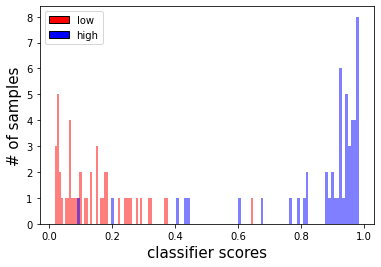

In [8]:
# check classifier predictions are similar to CLF training

saved_name = 'GENDER_CLF_SAVED_MODEL.h5' # new
clf_model_path = data_path + '/DISCOVERY-master/GENDER/' + saved_name
clf_model = load_model(clf_model_path , compile=True)

images3D = images.repeat(3, -1)   
images3D_clfscore = clf_model.predict(images3D)

_ = plt.hist(images3D_clfscore[true_labels==0] , 100, alpha = 0.5, color= 'r')
_ = plt.hist(images3D_clfscore[true_labels==1] , 100, alpha = 0.5, color= 'b')
# plt.title('Quality scores based on real images', fontsize=20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.xlabel("classifier scores", fontsize=15)
plt.ylabel("# of samples", fontsize=15)
plt.show()

In [9]:
# https://github.com/OwalnutO/SSIM-Loss-Tensroflow/blob/master/SSIM_loss_class.py

def tf_ssim(img1, img2, k1=0.03, k2=0.003, WS=7, data_range=1):
    
    size = 7
    sigma=1.5
    x_data, y_data = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    x_data = np.expand_dims(x_data, axis=-1)
    x_data = np.expand_dims(x_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)
    x = tf.constant(x_data, dtype=tf.float32)
    y = tf.constant(y_data, dtype=tf.float32)
    g = tf.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    window = g / tf.reduce_sum(g)
    
    (_, _, _, channel) = img1.shape# .as_list()
    window = tf.tile(window, [1, 1, channel, 1])
    mu1 = tf.nn.depthwise_conv2d(img1, window, strides = [1, 1, 1, 1], padding = 'SAME')
    mu2 = tf.nn.depthwise_conv2d(img2, window, strides = [1, 1, 1, 1], padding = 'SAME')
    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    img1_2 = img1*img1 #tf.pad(img1*img1, [[0,0], [0, WS//2], [0, WS//2], [0,0]], "CONSTANT")
    sigma1_sq = tf.subtract(tf.nn.depthwise_conv2d(img1_2, window, strides = [1 ,1, 1, 1], padding = 'SAME') , mu1_sq)
    img2_2 = img2*img2 #tf.pad(img2*img2, [[0,0], [0, WS//2], [0, WS//2], [0,0]], "CONSTANT")
    sigma2_sq = tf.subtract(tf.nn.depthwise_conv2d(img2_2, window, strides = [1, 1, 1, 1], padding = 'SAME') ,mu2_sq)
    img12_2 = img1*img2 #tf.pad(img1*img2, [[0,0], [0, WS//2], [0, WS//2], [0,0]], "CONSTANT")
    sigma1_2 = tf.subtract(tf.nn.depthwise_conv2d(img12_2, window, strides = [1, 1, 1, 1], padding = 'SAME') , mu1_mu2)
    c1 = (k1*data_range)**2
    c2 = (k2*data_range)**2
    ssim_map = ((2*mu1_mu2 + c1)*(2*sigma1_2 + c2)) / ((mu1_sq + mu2_sq + c1)*(sigma1_sq + sigma2_sq + c2))
    
    return ssim_map

# https://nmarkou.blogspot.com/2020/10/gaussian-filter-in-keras-code-snippet.html
# https://stackoverflow.com/questions/55643675/how-do-i-implement-gaussian-blurring-layer-in-keras

def _gaussian_kernel(kernlen=[21, 21], nsig=[3, 3]):
        assert len(nsig) == 2
        assert len(kernlen) == 2
        kern1d = []
        for i in range(2):
            interval = (2 * nsig[i] + 1.) / (kernlen[i])
            x = np.linspace(-nsig[i] - interval / 2., nsig[i] + interval / 2.,
                            kernlen[i] + 1)
            kern1d.append(np.diff(st.norm.cdf(x)))

        kernel_raw = np.sqrt(np.outer(kern1d[0], kern1d[1]))
        # divide by sum so they all add up to 1
        kernel = kernel_raw / kernel_raw.sum()
        return kernel

# Initialise to set kernel to required value
def kernel_init(shape, dtype):
    kernel = np.zeros(shape)
    kernel[:, :, 0, 0] = _gaussian_kernel([shape[0], shape[1]])
    return kernel
    
def gaussian_filter_block(input_layer,
                          kernel_size=3,
                          strides=(1, 1),
                          dilation_rate=(1, 1),
                          padding="same",
                          activation=None,
                          trainable=False,
                          use_bias=False):

    return keras.layers.DepthwiseConv2D(
        kernel_size=kernel_size,
        strides=strides,
        padding=padding,
        depth_multiplier=1,
        dilation_rate=dilation_rate,
        activation=activation,
        use_bias=use_bias,
        trainable=trainable,
        depthwise_initializer=kernel_init,
        kernel_initializer=kernel_init)(input_layer)

# @tf.keras.utils.register_keras_serializable(package='Custom', name='Wvar_reg')
def Wvar_reg(weight_matrix):
    return tf.math.reduce_mean(tf.math.variance(weight_matrix))

In [10]:
# load models
latent_dim = 350


model_path = data_path + '/DISCOVERY-master/GENDER/GENDER_DISCOVER_SAVED_MODELS/'
encoder = load_model(model_path + 'encoder' + '.h5' , compile=False, custom_objects={'ConvSN2D': ConvSN2D , 'DenseSN': DenseSN, 'Wvar_reg': Wvar_reg})
decoder = load_model(model_path + 'generator' + '.h5' , compile=False, custom_objects={'ConvSN2D': ConvSN2D , 'DenseSN': DenseSN, 'Wvar_reg': Wvar_reg})
recognizer = load_model(model_path + 'disentangleNET' + '.h5' , compile=False, custom_objects={'ConvSN2D': ConvSN2D , 'DenseSN': DenseSN, 'Wvar_reg': Wvar_reg})


#################################
# try:
#     ae_model = load_model(ae_model_path , compile=False, custom_objects={'ConvSN2D': ConvSN2D , 'DenseSN': DenseSN , 'Wvar_reg': Wvar_reg})
# except:
#     ae_model = load_model(ae_model_path , compile=False, custom_objects={'ConvSN2D': ConvSN2D , 'DenseSN': DenseSN, 'kernel_init': kernel_init})

# # ae_model = load_model(ae_model_path , compile=False)
    
# encoder = ae_model.get_layer('encoder')
# decoder = ae_model.get_layer('decoder')
# try:
#     discriminator1D = ae_model.get_layer('discriminator')
#     recognizer = ae_model.get_layer('recognizer')
# except:
#     f=1



In [11]:
# encode/decode images
try:
    z_dist, Escore = encoder.predict(images)
except:
    z_dist = encoder.predict(images) 
    

images_recon = decoder.predict(z_dist)
print(z_dist.shape)
latent_dim = z_dist.shape[1]


(100, 350)


real samples


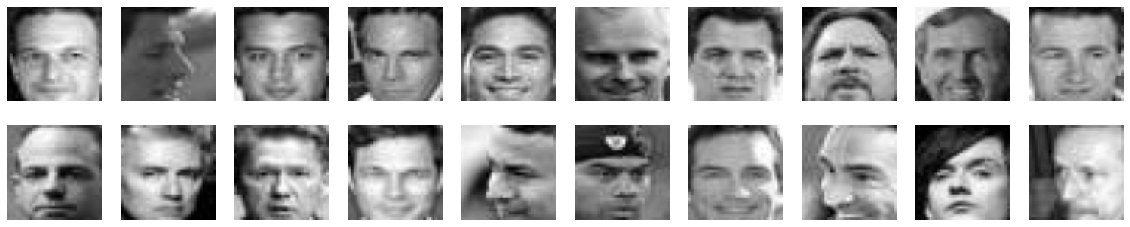


reconstructed samples


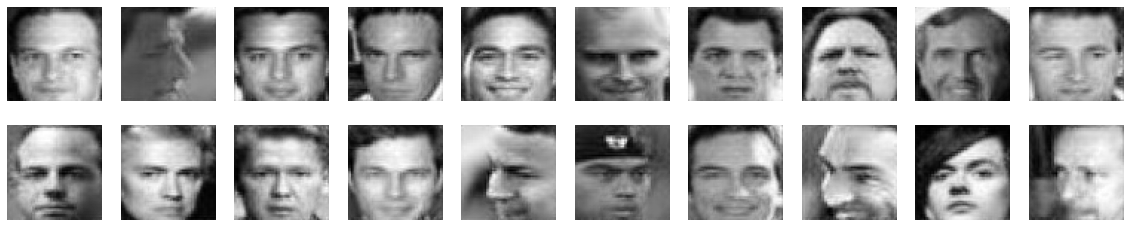

In [13]:
#  reconstruction
ids = range(20)
print('real samples')
sample_images(images[ids], 2,10) 
print('')
print('reconstructed samples')
sample_images(images_recon[ids], 2,10)


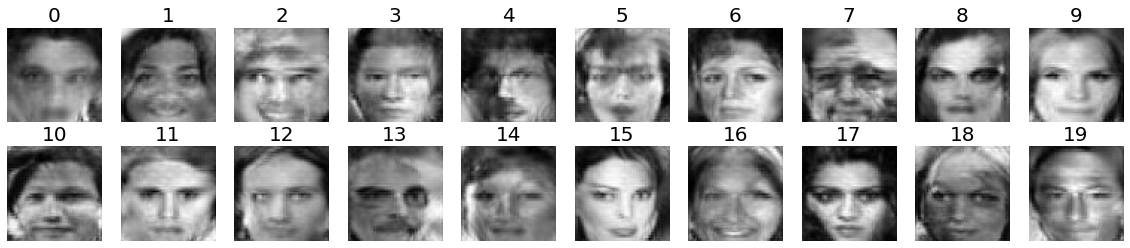

In [14]:
#  sample from normal distribution
n_samples = 20
z_samples = np.zeros((n_samples, z_dist.shape[1]))
for i in range(n_samples):
    for j in range(z_dist.shape[1]):
        ind = np.random.randint(0, z_dist.shape[0], 1)[0] # sample ids from images
        z_samples[i][j] = z_dist[ind][j]
imgs_samples = decoder.predict(np.expand_dims(z_samples, axis=-1))
sample_images_labels(imgs_samples, np.arange(0,z_samples.shape[0],1), 2,10)

VGG loss 0.40449986
CLF loss 0.38301292


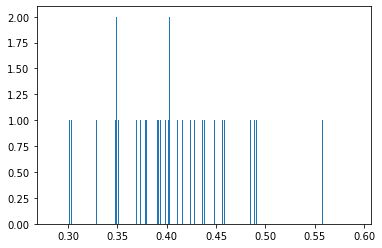

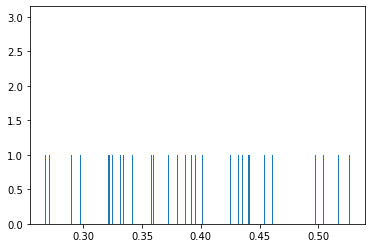

In [15]:
# calculating CLF and VGG perceptual loss

clf_outputs = [
               clf_model.get_layer('block2_conv1').output,
               clf_model.get_layer('block2_conv2').output,
               clf_model.get_layer('block3_conv2').output,
               clf_model.get_layer('block3_conv3').output,
               clf_model.get_layer('block5_conv2').output,
               clf_model.get_layer('block5_conv3').output,
               clf_model.get_layer('flatten').output,
               clf_model.get_layer('dense_1').output,]

CNN_clf_Model_outputs = Model(inputs=clf_model.input, outputs = clf_outputs)
CNN_clf_Model_outputs.trainable = False # we dont train the CNN

VGG_model = VGG19(weights="imagenet", include_top=False, input_shape=(img_rows, img_cols,3)) # ResNet50 , VGG16, VGG19
VGG_outputs = [
               # VGG_model.get_layer('block1_conv1').output,   
               # VGG_model.get_layer('block1_conv2').output,
               # VGG_model.get_layer('block2_conv1').output,
               # VGG_model.get_layer('block2_conv2').output,   
               VGG_model.get_layer('block3_conv1').output,   
               VGG_model.get_layer('block3_conv2').output,
               VGG_model.get_layer('block3_conv3').output,
               VGG_model.get_layer('block4_conv1').output,
               VGG_model.get_layer('block4_conv2').output,
               VGG_model.get_layer('block4_conv3').output,
               VGG_model.get_layer('block4_conv4').output,
               VGG_model.get_layer('block5_conv1').output,
               VGG_model.get_layer('block5_conv2').output,
               VGG_model.get_layer('block5_conv3').output,
               VGG_model.get_layer('block5_conv4').output,]           
            
VGG_Model_outputs = Model(inputs=VGG_model.input, outputs = VGG_outputs)
VGG_Model_outputs.trainable = False # we dont train the CNN

def model_perc_loss_wrapper(model):
    def model_perc_loss(y_true, y_pred):
        # weights = [1,1,1]
        img_outputs = model( y_true ) 
        recon_img_outputs = model( y_pred ) 
        layers_losses = []
        for i in range(len(recon_img_outputs)):
            layers_losses.append(K.mean(K.abs(img_outputs[i] - recon_img_outputs[i])))
        avg_loss = K.mean(tf.convert_to_tensor(layers_losses))
        return avg_loss
    return model_perc_loss

VGG_loss = []
CLF_loss = []
# for i in range(0,2625,525):
#     VGG_loss.append( model_perc_loss_wrapper(VGG_Model_outputs)(images[i:i+525].repeat(3, -1), images_recon[i:i+525].repeat(3, -1)).numpy() )
#     CLF_loss.append( model_perc_loss_wrapper(CNN_clf_Model_outputs)(images[i:i+525].repeat(3, -1), images_recon[i:i+525].repeat(3, -1)).numpy() )
# print('VGG loss' , np.array(VGG_loss).mean())
# print('CLF loss' , np.array(CLF_loss).mean())

for i in range(len(images)):
    VGG_loss.append( model_perc_loss_wrapper(VGG_Model_outputs)(images[i:i+1].repeat(3, -1), images_recon[i:i+1].repeat(3, -1)).numpy() )
    CLF_loss.append( model_perc_loss_wrapper(CNN_clf_Model_outputs)(images[i:i+1].repeat(3, -1), images_recon[i:i+1].repeat(3, -1)).numpy() )

print('VGG loss' , np.array(VGG_loss).mean())
print('CLF loss' , np.array(CLF_loss).mean())

_ = plt.hist(np.array(VGG_loss), 1000)
plt.show()
_ = plt.hist(np.array(CLF_loss), 1000)
plt.show()

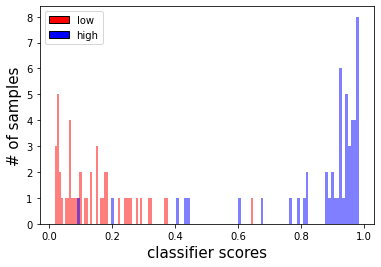

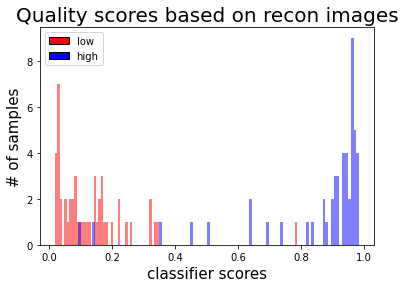

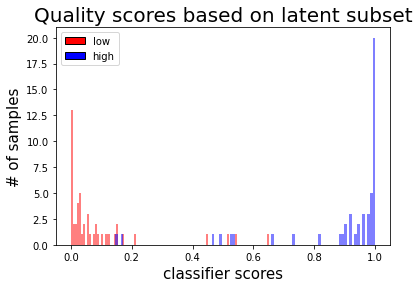

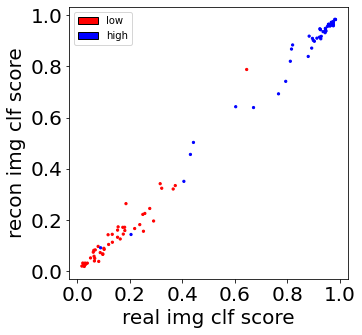

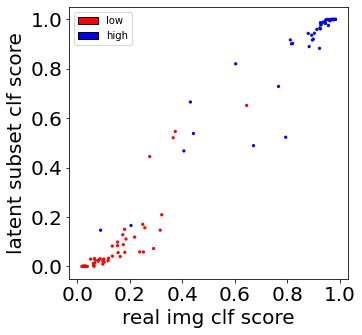

auc true vs real  0.982
auc true vs recon 0.9788
auc true vs z_score 0.99
mae(clf(x), clf(xrecon))  0.021227947
mae(clf(x), clf(z_score))  0.06578853


In [16]:
# real vs recon clf scores

images3D = images.repeat(3, -1)   
images3D_clfscore = clf_model.predict(images3D)

images_recon3D = images_recon.repeat(3, -1)   
images_recon3D_clfscore = clf_model.predict(images_recon3D)
###############################################
_ = plt.hist(images3D_clfscore[true_labels==0] , 100, alpha = 0.5, color= 'r')
_ = plt.hist(images3D_clfscore[true_labels==1] , 100, alpha = 0.5, color= 'b')
# plt.title('Quality scores based on real images', fontsize=20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.xlabel("classifier scores", fontsize=15)
plt.ylabel("# of samples", fontsize=15)
plt.show()

_ = plt.hist(images_recon3D_clfscore[true_labels==0] , 100, alpha = 0.5, color= 'r')
_ = plt.hist(images_recon3D_clfscore[true_labels==1] , 100, alpha = 0.5, color= 'b')
plt.title('Quality scores based on recon images', fontsize=20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.xlabel("classifier scores", fontsize=15)
plt.ylabel("# of samples", fontsize=15)
plt.show()

_ = plt.hist(Escore[true_labels==0] , 100, alpha = 0.5, color= 'r')
_ = plt.hist(Escore[true_labels==1] , 100, alpha = 0.5, color= 'b')
plt.title('Quality scores based on latent subset', fontsize=20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.xlabel("classifier scores", fontsize=15)
plt.ylabel("# of samples", fontsize=15)
plt.show()

###############################################

cols=[]
for l in true_labels:
    if l==0:
        cols.append('red')
    elif l==1:
        cols.append('blue')
plt.figure(figsize=(5,5))
plt.scatter(images3D_clfscore, images_recon3D_clfscore, c=cols, s=5, cmap='gray')
plt.xlabel("real img clf score", fontsize=20)
plt.ylabel("recon img clf score", fontsize=20)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(images3D_clfscore, Escore, c=cols, s=5, cmap='gray')
plt.xlabel("real img clf score", fontsize=20)
plt.ylabel("latent subset clf score", fontsize=20)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.show()


# calculate auc for real and recon imgs vs true labels (drop not aa or bb bc cb cc)

true_labels_0_1 = []
images3D_clfscore_0_1 = []
images_recon3D_clfscore_0_1 = []
Escore_0_1 = []
for i in range(len(true_labels)):
    if true_labels[i] == 0 or true_labels[i] == 1:
        true_labels_0_1.append(true_labels[i]) 
        images3D_clfscore_0_1.append(images3D_clfscore[i])
        images_recon3D_clfscore_0_1.append(images_recon3D_clfscore[i])
        Escore_0_1.append(Escore[i])

fpr, tpr, thresholds = metrics.roc_curve(true_labels_0_1, images3D_clfscore_0_1)
print('auc true vs real ' , metrics.auc(fpr, tpr))
recon_fpr, recon_tpr, recon_thresholds = metrics.roc_curve(true_labels_0_1, images_recon3D_clfscore_0_1)
print('auc true vs recon' ,metrics.auc(recon_fpr, recon_tpr))
recon_fpr, recon_tpr, recon_thresholds = metrics.roc_curve(true_labels_0_1, Escore_0_1)
print('auc true vs z_score' ,metrics.auc(recon_fpr, recon_tpr))
###############################################
# mae 
print('mae(clf(x), clf(xrecon)) ' , np.mean(np.abs(images3D_clfscore - images_recon3D_clfscore )) )
print('mae(clf(x), clf(z_score)) ' , np.mean(np.abs(images3D_clfscore - Escore )) )

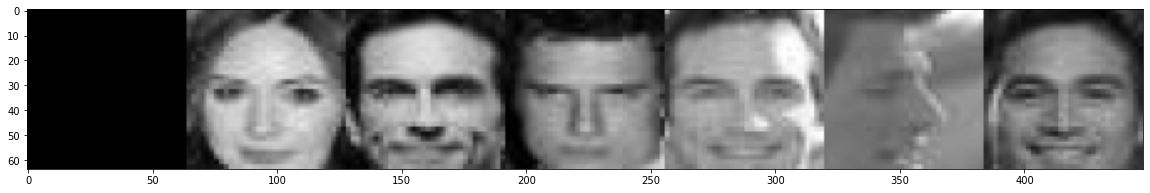

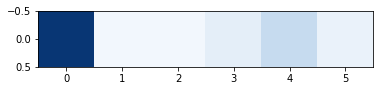

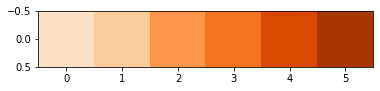

[[-2.0948539], [-1.4176657], [-0.22922647], [0.52295953], [1.4619708], [2.2336512]]


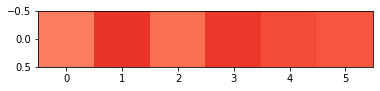

In [17]:
# images from different bin values 
tmp_imgs = []
tmp_scores = []
tmp_values = []
tmp_names = []
one_img = np.zeros((64,64))
ranges = np.linspace(-3,3,7)
dim=10 ##########################################
for i in range(len(ranges)):
    try:
        idx = np.where( (z_dist[:,dim] > ranges[i]) * (z_dist[:,dim] < ranges[i+1]) )[0] 
        rand_idx_in_range = np.random.randint(0, idx.shape, 1)[0]
        tmp_values.append( [z_dist[idx[rand_idx_in_range],dim]])
        tmp_imgs.append(images[idx[rand_idx_in_range]])
        # tmp_names.append(names[idx[rand_idx_in_range]])
        one_img = np.concatenate((one_img, images[idx[rand_idx_in_range]][:,:,0]), axis=-1)
        tmp_scores.append(np.array(images3D_clfscore_0_1)[idx[rand_idx_in_range]])
    except:
        f=0
tmp_imgs = np.array(tmp_imgs)
# sample_images_labels(tmp_imgs, tmp_scores)

plt.figure(figsize=(20,3))
plt.imshow(one_img, cmap='gray')
plt.show()
plt.imshow(np.array(tmp_scores).T, cmap='Blues' , vmin=0 , vmax=1)
plt.show()
plt.imshow(np.array(tmp_values).T, cmap='Oranges' , vmin=-3 , vmax=3)
plt.show()
print(tmp_values)


z_imgs, z_scores = encoder(tmp_imgs)
plt.imshow(np.expand_dims(z_imgs[:,0].numpy(), -1).T, cmap='Reds' , vmin=-3 , vmax=3)
plt.show()

# print(tmp_names)

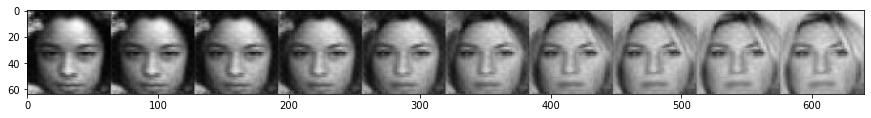

In [18]:
# interpolation between high and low images 


def slerp(val, low, high):
    omega = np.arccos(np.clip(np.dot(low/norm(low), high/norm(high)), -1, 1))
    so = sin(omega)
    if so == 0:
        return (1.0-val) * low + val * high
    return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high


# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2 # uniform #   
        # v = slerp(ratio, p1, p2)# spherical 
        vectors.append(v)
    return np.asarray(vectors)

low_idx = np.where(np.array(images3D_clfscore_0_1) >0.8)[0] # <0.2
low_rand_idx = np.random.randint(0, low_idx.shape, 1)[0]
low_image = images[low_idx[low_rand_idx]]
low_image_score = np.array(images3D_clfscore_0_1)[low_idx[low_rand_idx]]
low_z_dist = z_dist[low_idx[low_rand_idx]]

high_idx = np.where(np.array(images3D_clfscore_0_1) >0.8)[0]
high_rand_idx = np.random.randint(0, high_idx.shape, 1)[0]
high_image = images[high_idx[high_rand_idx]]
high_image_score = np.array(images3D_clfscore_0_1)[high_idx[high_rand_idx]]
high_z_dist = z_dist[high_idx[high_rand_idx]]


    
interpolated = interpolate_points(high_z_dist, low_z_dist)
decoded_interpolated = decoder.predict(interpolated)
plt.figure(figsize=(15,10))
plt.imshow(np.hstack((decoded_interpolated)), cmap='gray')


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

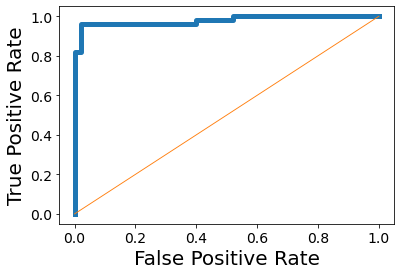

In [19]:
# ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(true_labels, images_recon3D_clfscore)  
plt.plot(fpr, tpr, linewidth=5)
plt.plot([0, 1], [0, 1], linewidth=0.9)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

baseline normal distribution vectors
latent_cov_loss  6326.535  off_diag_mean  0.07953952  diag_mean  0.994101881980896
z images
latent_cov_loss  7104.8647  off_diag_mean  0.08429036  diag_mean  1.0148565769195557


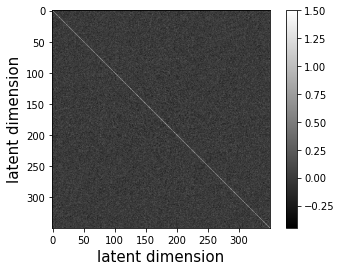

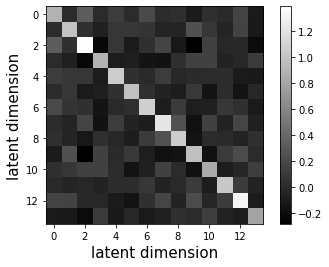

off diag max values (5)  [0.32777837 0.32777837 0.25710157 0.25710157 0.24313717]


In [20]:
# covariance

def get_off_diag_values(x):
    x_flat = tf.reshape(x,[-1])[:-1]
    x_reshape = tf.reshape(x_flat,[x.shape[0]-1, x.shape[0]+1])[:, 1:]
    off_diag_values = tf.reshape(x_reshape,[-1])
    return off_diag_values
def cov_loss_terms(z):
    cov = tfp.stats.covariance(z)
    diag_cov = tf.linalg.diag_part(cov)
    diag_cov_mean = tf.reduce_mean(diag_cov)
    diag_cov_loss = 1 - diag_cov_mean
    off_diag_values =  get_off_diag_values(cov)
    # A = tf.abs(off_diag_values)
    # A = tf.convert_to_tensor(A[A>0.05])
    # off_diag_loss = tf.reduce_mean(A)
    off_diag_loss = tf.reduce_mean(tf.abs(off_diag_values))
    return cov, diag_cov_loss , off_diag_loss
def calc_cov_loss(y_true, ypred):
    cov, diag_cov_loss , off_diag_loss = cov_loss_terms(y_true)
    cov_loss = 0.000001*diag_cov_loss + 1000000*off_diag_loss**2
    return cov_loss

############### random vecs
print('baseline normal distribution vectors')
var = 1.0
z_normal = tf.random.normal([z_dist.shape[0], z_dist.shape[1]], 0, var, tf.float32)
cov_loss = calc_cov_loss(z_normal, z_normal)
cov, diag_cov_loss , off_diag_loss = cov_loss_terms(z_normal)
print('latent_cov_loss ', cov_loss.numpy() , ' off_diag_mean ' , off_diag_loss.numpy() , ' diag_mean ', 1 - diag_cov_loss.numpy())


print('z images')
cov_loss = calc_cov_loss(z_dist, z_dist)
cov, diag_cov_loss , off_diag_loss = cov_loss_terms(z_dist)
print('latent_cov_loss ', cov_loss.numpy() , ' off_diag_mean ' , off_diag_loss.numpy() , ' diag_mean ', 1 - diag_cov_loss.numpy())

plt.imshow(cov, cmap='gray')
plt.xlabel("latent dimension", fontsize=15)
plt.ylabel("latent dimension", fontsize=15)
plt.colorbar()
plt.show()

plt.imshow(cov[0:14, 0:14], cmap='gray')
plt.xlabel("latent dimension", fontsize=15)
plt.ylabel("latent dimension", fontsize=15)
plt.colorbar()
plt.show()
print( 'off diag max values (5) ' , np.sort(get_off_diag_values(cov[0:14, 0:14]))[::-1][0:5] )


# z_cov = z_dist
# cov = tfp.stats.covariance(z_cov)
# diag_mean = tf.reduce_sum(tf.linalg.diag_part(cov)) / cov.shape[0]
# off_diag_mean = ( tf.reduce_sum(cov) - tf.reduce_sum(tf.linalg.diag_part(cov)) ) / (cov.shape[0]*2 - cov.shape[0])
# cov_loss = tf.reduce_mean((diag_mean - 1)**2) + tf.reduce_mean(off_diag_mean**2)
# print('latent_cov_loss ', cov_loss.numpy() , ' off_diag_mean ' , off_diag_mean.numpy() , ' diag_mean ', diag_mean.numpy())




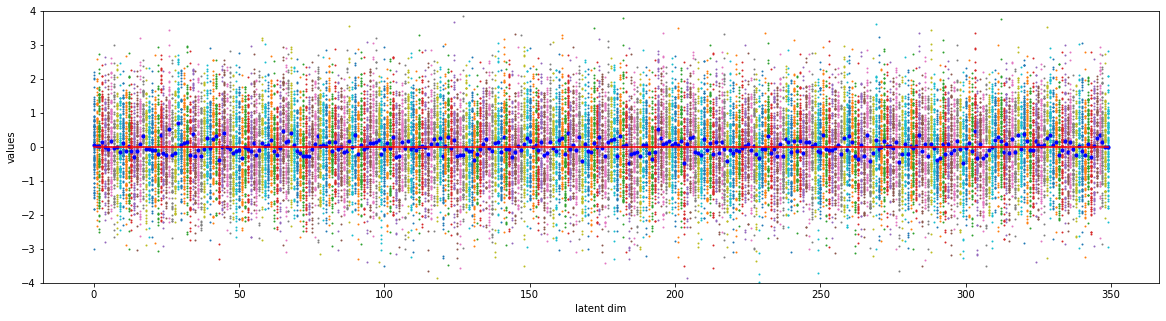

In [21]:
# distribution of dim
plt.figure(figsize=(20, 5))
for i in range (latent_dim):
    plt.scatter(i*np.ones((1,z_dist.shape[0])), z_dist[:, i], s=1)
    plt.scatter(i, np.mean(z_dist[:, i]), c='b', s=10)
    plt.xlabel('latent dim')
    plt.ylabel('values')
    plt.ylim([-4,4])
plt.plot(np.zeros((latent_dim,1)), 'r-', markersize=20)  
plt.show()

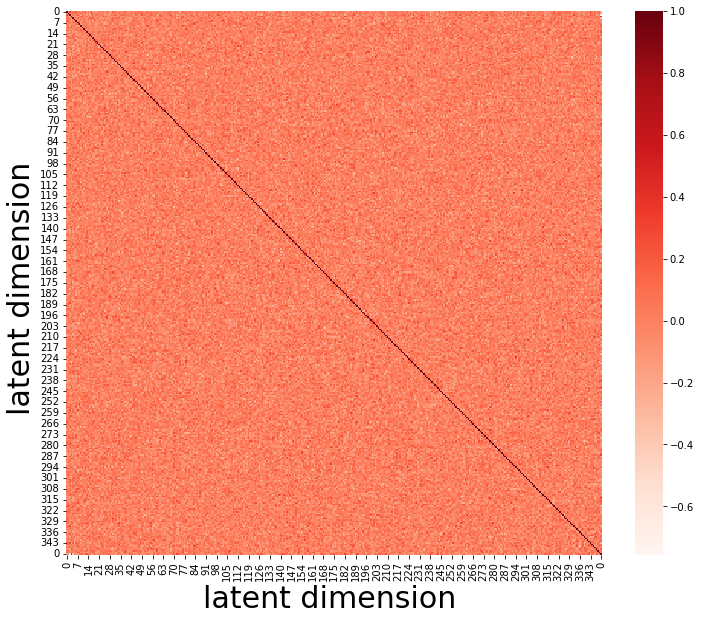

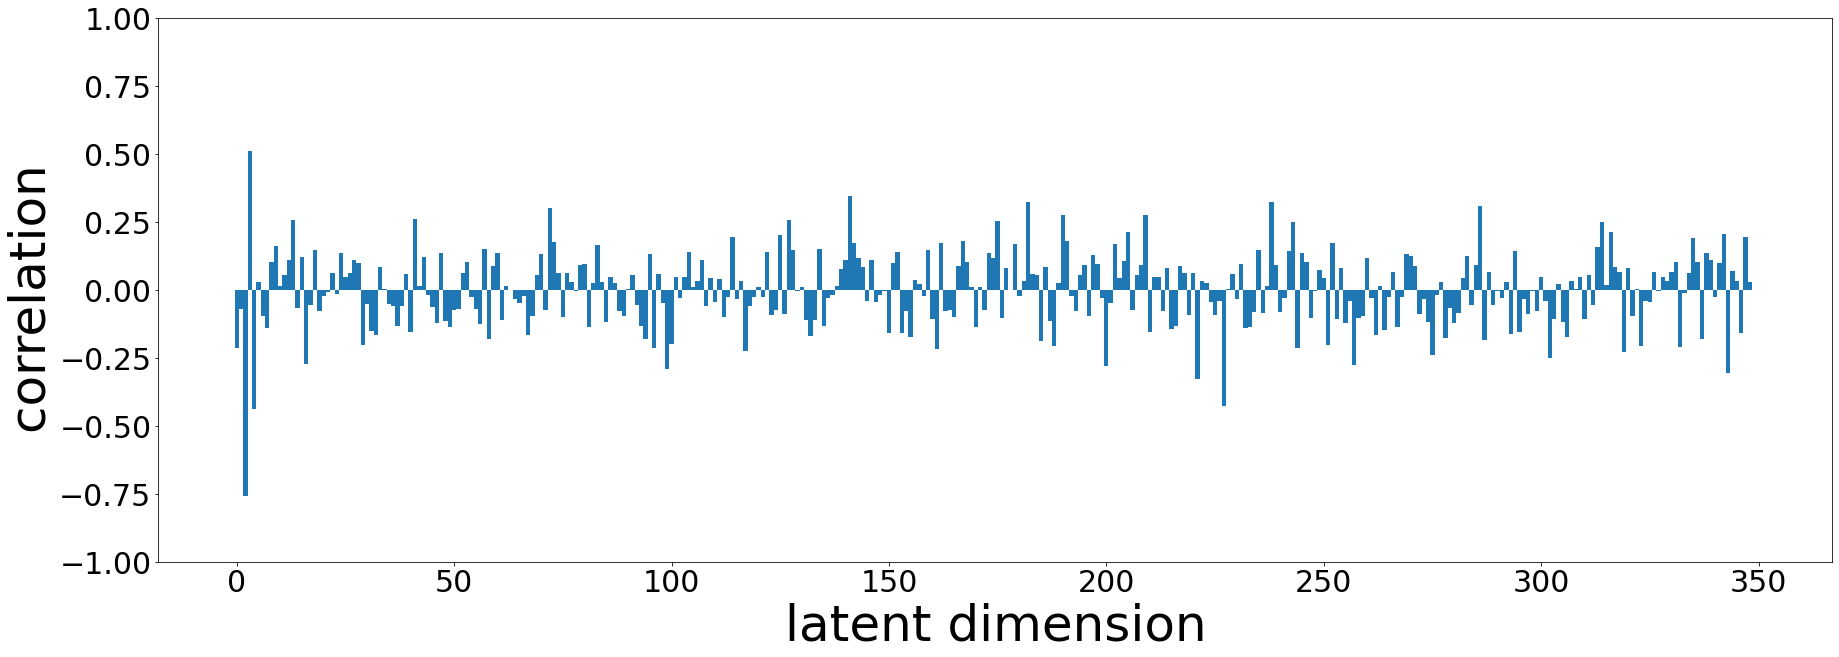

indices low to high [ 63 178 349 322 228 327 298 129  34 248  78 308 290  90 149  21 120 130
 333 171 169 105  10 237  23  42 263  62 138 315 276 148 137  44 304 158
  20 192 157 180  66 189  54 265 113  87 223  82 121 340 268 119 102 277
 199 291   5 241  77 261  84 348 292 136 296 307 273 222 181 329 115 116
 230  64 106 345 156 226 301 324 145 111 256 325 250 147 224 203 282 109
 110 328 101  98 212 211 103 309  65 201  25 300  86  30  35 207  17 194
 311 312  11 284  91 289  69 184  92 183  39  36  38 118 108  97 229  45
  22  76  26 220  52 334 218  74 288 330 326  14 318 279 266  55  51   1
 344 164 249 206 124  71  50 172 139 213 299 163 193  88  19 154 177 254
 234 214 320 240 317  33 281 186 236 144 272 217 271 297 126  59 166  79
 195 225 219 285 239 208 123  68   6 231 321 198  89 259  80 196 112 341
  28  75 165 151 168   8 176 336 331 246 258  53 247 253 204 310 160 303
 140 107  12 339 131  61 146 133  27  48 187  85 174 274 143 260 305  43
  15 255 280  46  56 283 270 19

In [22]:
# using all images find out which latent variables have high correlation to the classifier scores
df = pd.concat([pd.DataFrame(z_dist) , pd.DataFrame(images3D_clfscore)] , axis=1).reset_index()
df = df.drop( ['index'] , axis=1)

plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, cmap=plt.cm.Reds) # ,annot=True to see numbers
plt.xlabel("latent dimension ", fontsize=30)
plt.ylabel("latent dimension ", fontsize=30)
plt.show()

plt.figure(figsize=(30,10))
plt.bar(np.array(df.columns[:-1]), cor.iloc[-1].values[:-1] , width=1) # normalized
plt.xlabel("latent dimension", fontsize=50)
plt.ylabel("correlation ", fontsize=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim([-1,1])
plt.show()

print('indices low to high', np.argsort(np.abs(cor.iloc[-1].values[:-1])))
print('corscore low to high', np.round(np.sort(np.abs(cor.iloc[-1].values[:-1])),3))

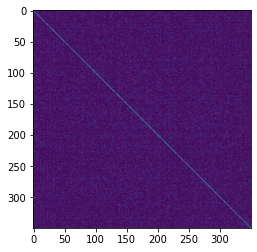

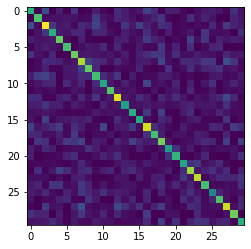

[[ 8.820e-01  5.000e-03  3.280e-01  1.000e-03  1.140e-01  2.000e-03
   1.980e-01  2.000e-03  2.600e-02 -1.040e-01  2.900e-02]
 [ 5.000e-03  9.980e-01  4.000e-02 -6.700e-02  6.900e-02  8.000e-02
   6.700e-02 -3.700e-02 -4.800e-02  2.430e-01  7.100e-02]
 [ 3.280e-01  4.000e-02  1.390e+00 -2.260e-01  7.200e-02 -1.050e-01
   3.400e-02  1.610e-01 -1.240e-01 -2.840e-01  1.400e-01]
 [ 1.000e-03 -6.700e-02 -2.260e-01  8.830e-01 -9.800e-02 -7.500e-02
  -1.490e-01 -1.630e-01  2.700e-02  1.540e-01  1.520e-01]
 [ 1.140e-01  6.900e-02  7.200e-02 -9.800e-02  1.063e+00  4.000e-02
  -5.000e-03  1.210e-01 -2.300e-02 -5.000e-03  3.000e-03]
 [ 2.000e-03  8.000e-02 -1.050e-01 -7.500e-02  4.000e-02  9.800e-01
   2.700e-02 -5.100e-02 -9.300e-02  8.500e-02 -1.550e-01]
 [ 1.980e-01  6.700e-02  3.400e-02 -1.490e-01 -5.000e-03  2.700e-02
   1.074e+00 -9.200e-02  1.010e-01 -8.300e-02 -6.300e-02]
 [ 2.000e-03 -3.700e-02  1.610e-01 -1.630e-01  1.210e-01 -5.100e-02
  -9.200e-02  1.222e+00  2.570e-01 -1.680e-01  1.5

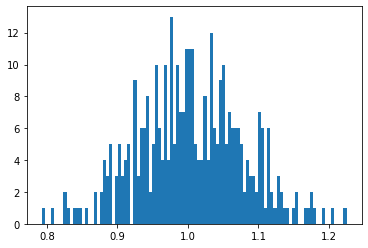

In [23]:
z_dist_ = z_dist - np.mean(z_dist, axis=0)
z_std = np.sqrt(np.var(z_dist_, axis=0))
cov = (z_dist_.T @ z_dist_) / (z_dist_.shape[0] )
plt.imshow(np.abs(cov))
plt.show()

plt.imshow(np.abs(cov[0:30, 0:30]))
plt.show()

_ = plt.hist(z_std, 100)

print(np.round(cov[0:11, 0:11], 3))
print(np.corrcoef(z_dist[0], z_dist[10], rowvar=False))

In [24]:
def get_off_diag_values(x):
    x_flat = tf.reshape(x,[-1])[:-1]
    x_reshape = tf.reshape(x_flat,[x.shape[0]-1, x.shape[0]+1])[:, 1:]
    off_diag_values = tf.reshape(x_reshape,[-1])
    return off_diag_values

def compute_barlow_loss(z_a, z_b):
    z_a2b_loss = tf.reduce_mean(tf.abs(z_a - z_b))
    z_a_norm = (z_a - tf.reduce_mean(z_a, axis=0)) #/ tf.math.reduce_std(z_a, axis=0)
    z_b_norm = (z_b - tf.reduce_mean(z_b, axis=0)) #/ tf.math.reduce_std(z_b, axis=0)
    cov = tf.matmul(z_a_norm, z_b_norm, transpose_a=True) / tf.cast(tf.shape(z_a)[0], z_a.dtype)  # Cross-correlation matrix
    on_diag = tf.linalg.diag_part(cov) # vector of vars (z_std**2)  positives

    on_diag_loss = tf.reduce_mean( tf.nn.relu(1 - tf.sqrt(on_diag)) )
    off_diag = get_off_diag_values(cov)
    off_diag_loss    = tf.reduce_mean(tf.abs( off_diag**2 ))
    
    # on_diag_loss = tf.reduce_mean( tf.nn.relu(1 - on_diag) ) # tf.reduce_mean(tf.pow(on_diag -1, 2))
    # off_diag = tf.reshape( tf.reshape( tf.reshape(cov, [-1])[:-1] , (tf.shape(cov)[0]-1, tf.shape(cov)[0]+1) )[:, 1:]  , [-1])
    # off_diag_loss = tf.reduce_mean(tf.pow(off_diag, 2))
    return cov, on_diag, off_diag, on_diag_loss, off_diag_loss, z_a2b_loss 

cov, on_diag, off_diag, on_diag_loss, off_diag_loss, z_a2b_loss  = compute_barlow_loss(z_dist, z_dist)

In [25]:
# mean and var of most correlated dimensions

sorted_dim = np.argsort(np.abs(cor.iloc[-1].values[:-1]))[::-1]
for i in range(15):
    print('dim:' , sorted_dim[i], '   mean:' , z_dist[:, i].mean(), '   var:' , z_dist[:, i].var(), '   corr:' , cor.iloc[-1].values[sorted_dim[i]])


dim: 2    mean: 0.069268286    var: 0.88177925    corr: -0.7561289122618415
dim: 3    mean: 0.017579885    var: 0.99755037    corr: 0.5115145766852275
dim: 4    mean: 0.036229152    var: 1.3902588    corr: -0.4381847726621551
dim: 227    mean: 0.15594026    var: 0.8825691    corr: -0.42789209468542916
dim: 141    mean: -0.0017413807    var: 1.0629401    corr: 0.3466095798688749
dim: 221    mean: -0.048277885    var: 0.9800408    corr: -0.3290425756830918
dim: 182    mean: 0.15942496    var: 1.0743799    corr: 0.3231808318735941
dim: 238    mean: -0.04375277    var: 1.2216585    corr: 0.32297342751517183
dim: 286    mean: -0.002975297    var: 1.0604806    corr: 0.3080628024633876
dim: 343    mean: -0.1478116    var: 0.97686064    corr: -0.3058831689227252
dim: 72    mean: 0.119616196    var: 0.84002733    corr: 0.3010980081715622
dim: 99    mean: -0.11279051    var: 1.0218    corr: -0.2923697116763601
dim: 200    mean: 0.023355827    var: 1.3209388    corr: -0.2799576578242754
dim: 209 

0


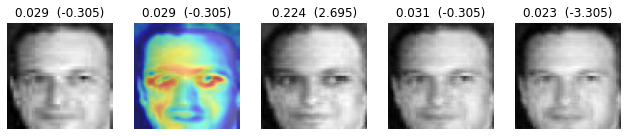

1


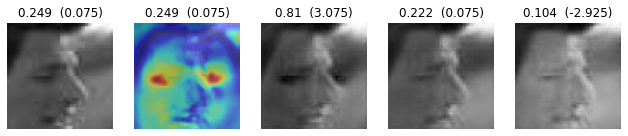

2


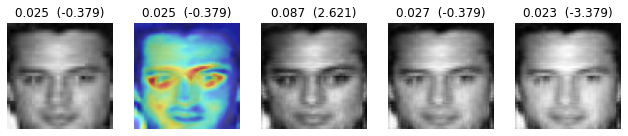

3


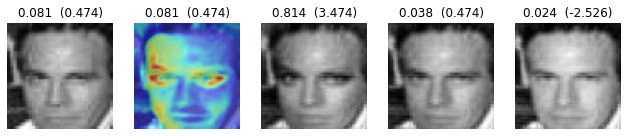

4


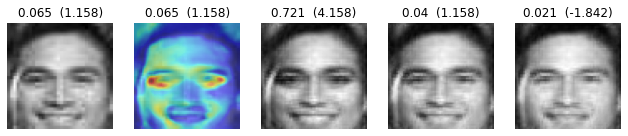

5


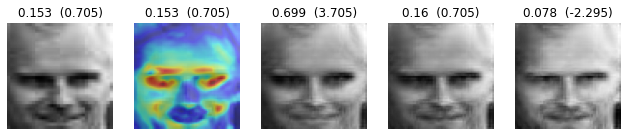

6


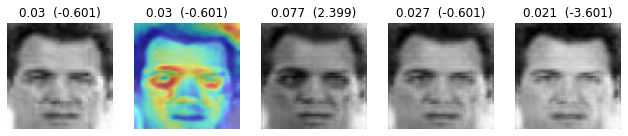

7


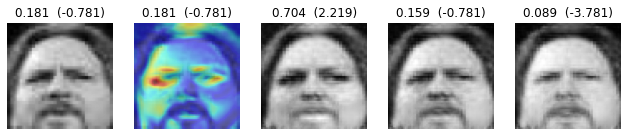

8


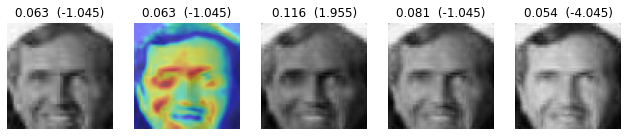

9


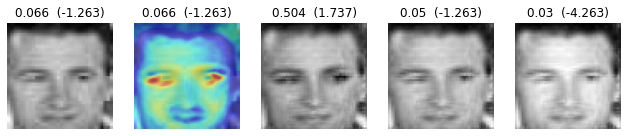

In [27]:

def interpretability(imgs, pert_dim, pert_value, ids):
    
    if sorted_dim[pert_dim] > 0 :
        plus_pert_value  =  pert_value
        minus_pert_value = -pert_value
    if sorted_dim[pert_dim] < 0 :
        plus_pert_value  = -pert_value
        minus_pert_value =  pert_value

    test_images_ = imgs # / 255 
    test_images_scores = clf_model( test_images_.repeat(3, -1) )
    test_z_images, test_z_scores  = encoder.predict(test_images_)
    test_recon_images = decoder.predict(test_z_images)
    test_recon_images_scores = clf_model(test_recon_images.repeat(3, -1))


    for idx in ids: # [7,11, 48,25, 9, 27, 39]: # range(200,300): 

        print(idx)

        latent_vec = test_z_images[idx]

        pert_latent_z_plus = np.copy(latent_vec)
        pert_latent_z_plus[pert_dim] = latent_vec[pert_dim] + plus_pert_value 
        pert_recon_img_plus = decoder.predict(np.expand_dims(pert_latent_z_plus, axis=0)) # decoder
        pert_plus_score = np.round(clf_model( pert_recon_img_plus.repeat(3, -1) ).numpy()[0][0],3)


        pert_latent_z_minus = np.copy(latent_vec) 
        pert_latent_z_minus[pert_dim] = latent_vec[pert_dim] + minus_pert_value 
        pert_recon_img_minus = decoder.predict(np.expand_dims(pert_latent_z_minus, axis=0))  # decoder
        pert_minus_score = np.round(clf_model( pert_recon_img_minus.repeat(3, -1) ).numpy()[0][0],3)


        diff_ssim = 1 - ssim(pert_recon_img_minus[0,:,:,0], pert_recon_img_plus[0,:,:,0], win_size=7,     K1=0.03 , K2=0.003,    sigma=0.5 , gradient=True, gaussian_weights = False , full=True)[2] # 1-grad, 2-ssim        
        # diff = pert_recon_img_minus[0,:,:,0] - pert_recon_img_plus[0,:,:,0]
        diff = np.abs(pert_recon_img_minus[0,:,:,0] - pert_recon_img_plus[0,:,:,0])
        diff = cv2.GaussianBlur(diff,(3,3),1) 

        fig, axs = plt.subplots(1, 5, figsize=(11,7))

        axs[0].imshow(test_images_[idx], cmap='gray')
        axs[0].set_title(str(np.round(test_images_scores[idx].numpy()[0],3)) + '  (' + str(np.round(test_z_images[idx][pert_dim],3)) + ')' )
        axs[0].axis('off')

        axs[1].imshow(test_images_[idx], cmap='gray', alpha=0.8)
        axs[1].imshow(diff, alpha=0.5, cmap='jet') #  , vmin=-0.4, vmax=0.4
        axs[1].set_title(str(np.round(test_images_scores[idx].numpy()[0],3)) + '  (' + str(np.round(test_z_images[idx][pert_dim],3)) + ')' )
        axs[1].axis('off')

        axs[2].imshow(pert_recon_img_plus[0], cmap='gray')
        axs[2].set_title(str(pert_plus_score) + '  (' + str(np.round(pert_latent_z_plus[pert_dim],3)) + ')' )
        axs[2].axis('off')

        axs[3].imshow(test_recon_images[idx], cmap='gray')
        axs[3].set_title(str(np.round(test_recon_images_scores[idx].numpy()[0],3)) + '  (' + str(np.round(test_z_images[idx][pert_dim],3)) + ')')
        axs[3].axis('off')

        axs[4].imshow(pert_recon_img_minus[0], cmap='gray')
        axs[4].set_title(str(pert_minus_score) + '  (' + str(np.round(pert_latent_z_minus[pert_dim],3)) + ')')
        axs[4].axis('off')

        plt.show()

pert_dim = 3 
pert_value = 3
ids =  range(0,10) # [7,11, 48,25, 9, 27, 39, 52, 83, 88, 92, 94, 118, 136, 148, 174] # range(200,300)
interpretability(images, pert_dim, pert_value, ids)